# Transfer learning from multiple pre-trained computer vision models 

This notebook provides the details for the blog post: <b> Transfer learning from multiple pre-trained computer vision models </b>

tl;dr using pre-trained models as a mechanism to represent images in a new dataset we are able to acheive excellent classification accuracy with a simple linear classifier. Stacking multiple pre-trained models is even better! 




In [1]:
import os 
import pandas as pd 
import numpy as np 

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from mlxtend.classifier import StackingClassifier
from mlxtend.feature_selection import ColumnSelector

import matplotlib.pyplot as plt 
%matplotlib inline 

import tensorflow as tf
import keras 
from keras.applications import VGG19, InceptionV3, Xception, ResNet50

from keras.applications.imagenet_utils import preprocess_input as preprocess_type1
from keras.applications.inception_v3 import preprocess_input as preprocess_type2

from cub_util import CUB200

Using TensorFlow backend.


We assume that you have downloaded the CUB-200 dataset 

```bash
curl http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz | tar -xz
```

and placed the resulting folder under ~/data/blog, so that ~/data/blog/images is the folder containing the actual images. Any path is fine, but edit the following accordingly:

In [2]:
NUM_CLASSES = 200
DATA_DIR = os.path.expanduser(os.path.join("~", "data", "blog")) 
CUB_DIR = os.path.join(DATA_DIR, "CUB_200_2011", "images")
FEATURES_DIR = os.path.join(DATA_DIR, "features")

In [3]:
# If this fails, the CUB-200 dataset is not in the rigt place... :) 
assert os.path.exists(CUB_DIR)

## Load and show 
In this segment we load the dataset and plot some of the images. 

In [4]:
X, _ = CUB200(CUB_DIR, image_size=(100, 100)).load_dataset(num_per_class=5)

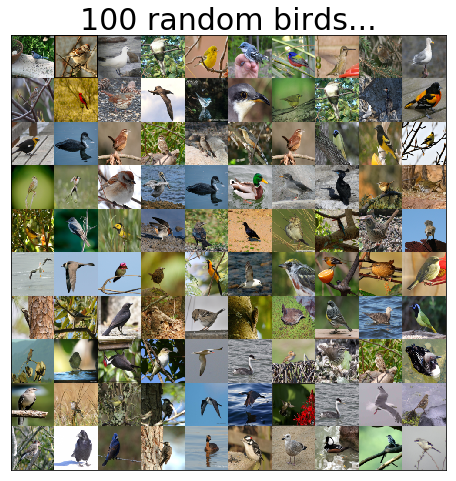

In [6]:
n = X.shape[0]
rnd_birds = np.vstack([np.hstack([X[np.random.choice(n)] for i in range(10)])
                       for j in range(10)])
plt.figure(figsize=(8, 8))
plt.imshow(rnd_birds / 255)
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)
plt.title("100 random birds...", fontsize=30)

## Representation and first model 

We start with a utility to load the pre-trained image representations. Depending on the hardware, this may take quite a long time, so in order not to keep doing this, we will save the feature files and re-load them when required.  

In [9]:
def load_features_compute_once(model, im_size, preprocess, save_path):
        
    if os.path.exists(save_path):
        data = pd.read_csv(save_path, compression='gzip', header=0, index_col=0)
        X = data.values 
        y = data.index.values
    else:
        X, y = CUB200(CUB_DIR, image_size=im_size).load_dataset()
        X = model(include_top=False, weights="imagenet", pooling='avg').predict(preprocess(X))
        pd.DataFrame(X, index=y).to_csv(save_path, compression='gzip', header=True, index=True)

    return X, y

Now we are are eady for the first classifier. We load (or compute) the ResNet representation, and feed it into a linear SVM, in a 3-fold cross-validataion procedure. 

In [10]:
X_resnet, y = load_features_compute_once(ResNet50, (244, 244), preprocess_type1, 
                                         os.path.join(FEATURES_DIR, "CUB200_resnet"))

In [13]:
X_resnet.shape

(11788, 2048)

In [11]:
clf = LinearSVC()
results = cross_val_score(clf, X_resnet, y, cv=3, n_jobs=-1)

In [12]:
print(results)
print("Overall accuracy: {:.3}".format(np.mean(results) * 100.))

[ 0.62522158  0.62344583  0.62852745]
Overall accuracy: 62.6


## Stacking 
Stacking is the process of applying multiple classifiers, and then feeding the output of these first stage classifiers to a second, meta-classifier which gives the final decision. 

The way we will use this method here is by running a first-stage classifier on each of the 4 pre-trained representations (ResNet, VGG19, Inception, and Xception). The output of these is averaged and fed into a second-stage meta-classifier. This method is under-utilized but often produces excellent results! As we see in a sec... 


In [26]:
X_resnet, y = load_features_compute_once(ResNet50, (244, 244), preprocess_type1, 
                                         os.path.join(FEATURES_DIR, "CUB200_resnet"))

X_vgg, _ = load_features_compute_once(VGG19, (244, 244), preprocess_type1, 
                                         os.path.join(FEATURES_DIR, "CUB200_VGG19"))

X_incept, _ = load_features_compute_once(InceptionV3, (299, 299), preprocess_type2, 
                                         os.path.join(FEATURES_DIR, "CUB200_inception"))

X_xcept, _ = load_features_compute_once(Xception, (299, 299), preprocess_type2, 
                                         os.path.join(FEATURES_DIR, "CUB200_xception"))

We put all the features in a single matrix, and keep the index to the beginning of each of the individual representation blocks. This is convenient for a pipeline, in which we select a block of columns and feed them into a classifier. 

In [54]:
X_all = np.hstack([X_vgg, X_resnet, X_incept, X_xcept])
inx = np.cumsum([0] + [X_vgg.shape[1], X_resnet.shape[1], X_incept.shape[1], X_xcept.shape[1]])

The ```StackingClassifier``` needs numeric class labels, so we encode the original ```str``` class names. 

In [62]:
y = LabelEncoder().fit_transform(y)

The first stage classifiers will be ```LogisticRegression``` and the second stage a ```LinearSVC```. The pipeline for the first stage is simply selected the correct columns from the matrix we built before with all the representations (this is simply a convenience so that we may use a single matrix for the representation data). 

Happily, ```mlxtend.classifier.StackingClassifier``` is ```sklearn``` compatible, so we can use it with the good-old cross validation procedure we used before. 

In [63]:
base_classifier = LogisticRegression
meta_classifier = LinearSVC

pipes = [make_pipeline(ColumnSelector(cols=list(range(inx[i], inx[i+1]))), base_classifier())
         for i in range(4)]

stacking_classifier = StackingClassifier(classifiers=pipes, meta_classifier=meta_classifier(), 
                                         use_probas=True, average_probas=True, verbose=1)

results = cross_val_score(stacking_classifier, X_all, y, cv=3, n_jobs=-1)

print(results)
print("Overall accuracy: {:.3}".format(np.mean(results) * 100.))

Fitting 4 classifiers...
Fitting classifier1: pipeline (1/4)
Fitting 4 classifiers...
Fitting classifier1: pipeline (1/4)
Fitting 4 classifiers...
Fitting classifier1: pipeline (1/4)
Fitting classifier2: pipeline (2/4)
Fitting classifier2: pipeline (2/4)
Fitting classifier2: pipeline (2/4)
Fitting classifier3: pipeline (3/4)
Fitting classifier3: pipeline (3/4)
Fitting classifier3: pipeline (3/4)
Fitting classifier4: pipeline (4/4)
Fitting classifier4: pipeline (4/4)
Fitting classifier4: pipeline (4/4)
[ 0.74221322  0.74194367  0.75115444]
Overall accuracy: 74.5


These results are pretty awesome (especially in the metric of accuracy per lines of code!)